In [1]:
#Redo for the bug mci+ad                            mci vs cn             ad vs cn
"""
pyder Editor

This is a temporary script file.
"""

import os
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn.svm import OneClassSVM
from nilearn.input_data import MultiNiftiMasker
import array as arr
from sklearn.model_selection import ShuffleSplit
from sklearn import svm
from sklearn.model_selection import cross_val_score
import scipy.io as spio
import pandas as pd
import scipy.ndimage as ndimage
from scipy import misc
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
#### modify the path here
absolute_path = '/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/'
data_path = 'con0005_csf/'

regex_filter = 'wp1_*'
delcode_cov = '/home/kadajji/hydra-work/delcode_cov1079.mat'

In [3]:
def create_confusion_matrix(test_label ,prediction, classifier):
    print(np.unique(test_label,return_counts=True))
    cm = confusion_matrix(test_label, prediction, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=clf.classes_)
    disp.plot()

    plt.show()

In [4]:

def plotting_roc_auc_curve(test_label, prediction):
    false_Positive_Rate, true_positive_rate, thresholds = metrics.roc_curve(test_label, prediction)
    roc_auc = metrics.auc(false_Positive_Rate, true_positive_rate)
    display = metrics.RocCurveDisplay(fpr=false_Positive_Rate, tpr=true_positive_rate, roc_auc=roc_auc,
                                      estimator_name='SVM')
    display.plot()

    plt.show()

In [5]:
def read_nifti(absolute_path, data_path, regex_filter, mask="/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/temp/mask01.nii", smooth=None):
     start_time = datetime.now()
     absolute_path = str(absolute_path)
     regex_filter = str(regex_filter)
     if(mask):
         #mask = absolute_path + str(mask)
         niftimasker = MultiNiftiMasker(mask_img=mask, smoothing_fwhm=smooth, n_jobs=-2)
     else:
        niftimasker = MultiNiftiMasker(smoothing_fwhm=smooth, n_jobs=-2)
     # mask images and get data
     data_folder = absolute_path + str(data_path)
     list_path = []
     subjs = []
     for files in os.listdir(data_folder):
         if re.match(regex_filter, files):
             image_path = data_folder + files
             list_path.append(image_path)
             subject_name = os.path.basename(files).split('_')[3]
             subject_name = os.path.basename(subject_name).split('.')[0]
             subjs.append(subject_name)
     print("Reading "+ regex_filter +" volume data please wait.........")
     
     list_path = np.sort(list_path)
     subjs = np.sort(subjs)
     x = niftimasker.fit_transform(list_path)
     x = np.vstack(x)
     subjects_id  = pd.DataFrame()
     subjects_id['subjs'] = subjs
     data_matrix = pd.DataFrame(x, dtype='float64')
     end_time = datetime.now()
     time = end_time-start_time
     print("Total time in minutes :", float(time.total_seconds()/60))
     return data_matrix, subjects_id

In [6]:
def get_data_mat(mat_url):
     dat = spio.loadmat(mat_url, squeeze_me=True)
     demo = dat['Demo']
     body = dat['Body']
     gen = dat['Gen']
     csf = dat['Csf']
     cog = dat['Cog']
     vol = dat['Vol']
     cog = cog['X'][()]
     csf = csf['X'][()]
     delcode_data = pd.DataFrame()
     delcode_data['subjs'] = dat['IDs'][()]
     delcode_data['id'] = demo['IDn'][()]
     delcode_data['age'] = demo['age_bl'][()]
     delcode_data['bmi'] = body['bmi'][()]
     delcode_data['diag'] = demo['diag_bl'][()]
     delcode_data['sex'] = demo['sex'][()]
     delcode_data['edu'] = demo['edu'][()]
     delcode_data['fmem'] = cog[:,21]
     return delcode_data

In [7]:
data, subjects = read_nifti(absolute_path, data_path, regex_filter)

Reading wp1_* volume data please wait.........
Total time in minutes : 0.15680738333333333


In [8]:
delcode_data = get_data_mat(delcode_cov)
subjects['age'] = subjects.subjs.map(delcode_data.set_index('subjs')['age'])
subjects['edu'] = subjects.subjs.map(delcode_data.set_index('subjs')['edu'])
subjects['sex'] = subjects.subjs.map(delcode_data.set_index('subjs')['sex'])
subjects['diag'] = subjects.subjs.map(delcode_data.set_index('subjs')['diag'])

In [9]:
subjects = subjects.dropna()

In [10]:
len(subjects)

493

#### todo write with crossvalidation

In [11]:
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

scoring = ['roc_auc','f1_weighted']
parameters = {'kernel':['linear','rbf'], 'C': [i for i in np.arange(0.00001,.01,0.001)]}

In [12]:
def make_train_test_diag_split(diag1,diag2):
    Y_train, Y_test = train_test_split(subjects, test_size = 0.25,random_state=55)
    X_train = pd.DataFrame(data, index=Y_train.index)
    X_test= pd.DataFrame(data, index=Y_test.index)
    
    Y_test['diag'] = Y_test['diag'].astype('int')
    Y_train['diag'] = Y_train['diag'].astype('int')
    #filter diag1 and diag2 on train dataset and labels
    X_train_diag1 = X_train.loc[X_train.index[Y_train['diag']==diag1]]
    X_train_diag2 = X_train.loc[X_train.index[Y_train['diag']==diag2]]
    X_train_diag = X_train_diag1.append(X_train_diag2)

    Y_train_diag1 = Y_train.loc[Y_train.index[Y_train['diag']==diag1]]
    Y_train_diag2 = Y_train.loc[Y_train.index[Y_train['diag']==diag2]]
    Y_train_diag = Y_train_diag1.append(Y_train_diag2)

    #Rename Y labels to 0 and 1
    Y_train_diag.loc[Y_train_diag['diag'] == diag1, 'diag'] = 0
    Y_train_diag.loc[Y_train_diag['diag'] == diag2, 'diag'] = 1


    #filter diag1 and diag2 on test dataset and labels
    X_test_diag1 = X_test.loc[X_test.index[Y_test['diag']==diag1]]
    X_test_diag2 = X_test.loc[X_test.index[Y_test['diag']==diag2]]
    X_test_diag = X_test_diag1.append(X_test_diag2)


    Y_test_diag1 = Y_test.loc[Y_test.index[Y_test['diag']==diag1]]
    Y_test_diag2 = Y_test.loc[Y_test.index[Y_test['diag']==diag2]]
    Y_test_diag = Y_test_diag1.append(Y_test_diag2)


    #Rename Y labels to 0 and 1

    Y_test_diag.loc[Y_test_diag['diag'] == diag1, 'diag'] = 0
    Y_test_diag.loc[Y_test_diag['diag'] == diag2, 'diag'] = 1
    trainingsamples = np.unique(Y_train_diag.diag,return_counts=True)
    print("number of training samples " + str(trainingsamples))
    testsamples = np.unique(Y_test_diag.diag,return_counts=True)
    print("number of testing samples " + str(testsamples))

    return X_train_diag,X_test_diag,Y_train_diag,Y_test_diag



CN = 0
SCD = 1
MCI = 2
AD = 5
ADR = 100



### CN vs SCD

/tmp/ipykernel_47077/550404812.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test['diag'] = Y_test['diag'].astype('int')
/tmp/ipykernel_47077/550404812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train['diag'] = Y_train['diag'].astype('int')


number of training samples (array([0, 1]), array([116, 152]))
number of testing samples (array([0, 1]), array([36, 52]))
 tuning for scoring roc_auc 
best parameters {'C': 1e-05, 'kernel': 'linear'}
cross validation results {'mean_fit_time': array([3.14033146, 3.11943493, 3.00724978, 3.2813314 , 3.05258503,
       3.06497216, 3.19534292, 3.16271439, 3.04674072, 3.01951041]), 'std_fit_time': array([0.05706294, 0.13599639, 0.09038413, 0.24919967, 0.13039242,
       0.03269582, 0.1657377 , 0.08921736, 0.06110057, 0.02120169]), 'mean_score_time': array([1.26161976, 1.31769471, 1.21148305, 1.23979549, 1.24897799,
       1.13518925, 1.33468924, 1.267946  , 1.2368783 , 1.2703361 ]), 'std_score_time': array([0.0374496 , 0.09827615, 0.12930937, 0.08252354, 0.07715382,
       0.06408135, 0.18452296, 0.08869837, 0.11253867, 0.102918  ]), 'param_C': masked_array(data=[1e-05, 0.00101, 0.00201, 0.00301, 0.00401, 0.00501,
                   0.00601, 0.00701, 0.00801, 0.00901],
             mask=[Fals

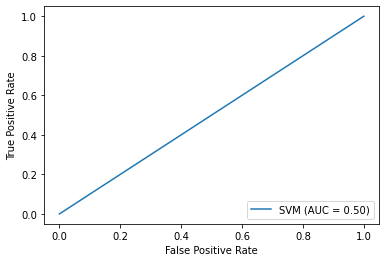

(array([0, 1]), array([36, 52]))


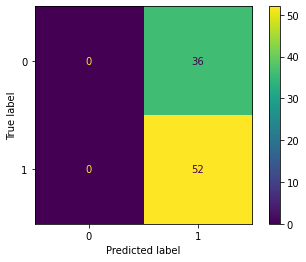

 tuning for scoring f1_weighted 
best parameters {'C': 0.00101, 'kernel': 'linear'}
cross validation results {'mean_fit_time': array([3.12046585, 3.08367653, 3.70161943, 3.24717703, 3.47519069,
       3.41623068, 3.06970725, 3.3707304 , 3.42672286, 3.26490612]), 'std_fit_time': array([0.1736421 , 0.17313783, 0.48922317, 0.16621495, 0.33973633,
       0.03248972, 0.09974612, 0.09699419, 0.22226551, 0.13199903]), 'mean_score_time': array([1.14439311, 1.33337297, 1.32991395, 1.21663189, 1.31868882,
       1.40009518, 1.28516264, 1.368852  , 1.23381667, 1.28700824]), 'std_score_time': array([0.08462177, 0.16857045, 0.10933588, 0.08514828, 0.11547317,
       0.09183764, 0.05586127, 0.1233733 , 0.06218354, 0.11242556]), 'param_C': masked_array(data=[1e-05, 0.00101, 0.00201, 0.00301, 0.00401, 0.00501,
                   0.00601, 0.00701, 0.00801, 0.00901],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
      

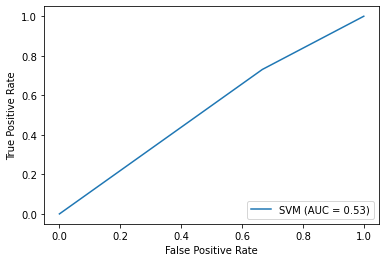

(array([0, 1]), array([36, 52]))


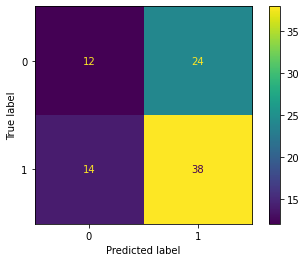

In [13]:
X_train_diag,X_test_diag,Y_train_diag,Y_test_diag = make_train_test_diag_split(CN,SCD)
from sklearn.metrics import make_scorer,roc_auc_score,f1_score
from sklearn.model_selection import StratifiedKFold
#Create a svm Classifier
parameters = {'kernel':['linear'], 'C': [i for i in np.arange(0.00001,.01,0.001)]}

svc = svm.SVC()
for score in scoring:
    print( " tuning for scoring %s " % score)
    clf = GridSearchCV(svc, parameters,cv=StratifiedKFold(5,shuffle=True,random_state=55),refit=True,scoring="%s" % score)

    #y_score = clf.fit(X_train, Y_train.sex).decision_function(X_test)
    clf.fit(X_train_diag, Y_train_diag.diag)
    print("best parameters", clf.best_params_)
    print("cross validation results", clf.cv_results_)
    print("Best scores ", clf.best_score_)
    y_pred = clf.predict(X_test_diag)
    print(" F1 score on test set ---- " , f1_score(Y_test_diag.diag, y_pred, average='weighted'))
    plotting_roc_auc_curve(Y_test_diag.diag,y_pred)
    create_confusion_matrix(Y_test_diag.diag,y_pred,clf)

### CN vs MCI

/tmp/ipykernel_47077/550404812.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test['diag'] = Y_test['diag'].astype('int')
/tmp/ipykernel_47077/550404812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train['diag'] = Y_train['diag'].astype('int')


number of training samples (array([0, 1]), array([116,  48]))
number of testing samples (array([0, 1]), array([36, 17]))
 tuning for scoring f1_weighted 
best parameters {'C': 0.00101, 'kernel': 'linear'}
cross validation results {'mean_fit_time': array([1.91646557, 1.91246009, 1.84114923, 1.91592474, 2.00589194,
       1.96459336, 1.87185678, 2.10671453, 1.9589922 , 1.85254579]), 'std_fit_time': array([0.08055797, 0.09690197, 0.10602997, 0.10298901, 0.10576613,
       0.08015845, 0.08767918, 0.15605741, 0.19416988, 0.05302181]), 'mean_score_time': array([1.05238333, 1.02389345, 1.00483575, 1.09792523, 0.9856782 ,
       1.08371077, 1.03530564, 1.09065213, 1.03625116, 0.95250173]), 'std_score_time': array([0.03853981, 0.08388301, 0.0649079 , 0.10982392, 0.03069832,
       0.06912077, 0.05861486, 0.11921005, 0.09709254, 0.04471852]), 'param_C': masked_array(data=[1e-05, 0.00101, 0.00201, 0.00301, 0.00401, 0.00501,
                   0.00601, 0.00701, 0.00801, 0.00901],
             mask

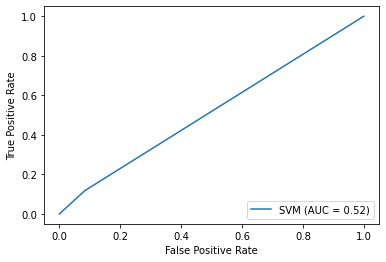

(array([0, 1]), array([36, 17]))


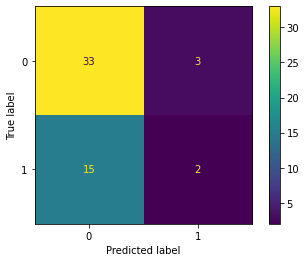

In [14]:
X_train_diag,X_test_diag,Y_train_diag,Y_test_diag = make_train_test_diag_split(CN,MCI)


#Create a svm Classifier
svc = svm.SVC(tol=0.00000001)
scoring = ['f1_weighted']
parameters = {'kernel':['linear'], 'C': [i for i in np.arange(0.00001,.01,0.001)]}

#Create a svm Classifier
svc = svm.SVC(cache_size=10000)
parameters = {'kernel':['linear'], 'C': [i for i in np.arange(0.00001,.01,0.001)]}

for score in scoring:
    print( " tuning for scoring %s " % score)
    clf = GridSearchCV(svc, parameters,cv=StratifiedKFold(5,shuffle=True,random_state=55),refit=True,scoring="%s" % score)

    #y_score = clf.fit(X_train, Y_train.sex).decision_function(X_test)
    clf.fit(X_train_diag, Y_train_diag.diag)
    print("best parameters", clf.best_params_)
    print("cross validation results", clf.cv_results_)
    print("Best scores ", clf.best_score_)
    y_pred = clf.predict(X_test_diag)
    print(" F1 score on test set ---- " , f1_score(Y_test_diag.diag, y_pred, average='weighted'))

    plotting_roc_auc_curve(Y_test_diag.diag,y_pred)
    create_confusion_matrix(Y_test_diag.diag,y_pred,clf)

### CN vs AD

/tmp/ipykernel_47077/550404812.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test['diag'] = Y_test['diag'].astype('int')
/tmp/ipykernel_47077/550404812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train['diag'] = Y_train['diag'].astype('int')


number of training samples (array([0, 1]), array([116,  17]))
number of testing samples (array([0, 1]), array([36,  4]))
 tuning for scoring f1_weighted 
best parameters {'C': 0.00201, 'kernel': 'linear'}
cross validation results {'mean_fit_time': array([1.43174043, 1.53874607, 1.52659383, 1.54239502, 1.54298553,
       1.58864985, 1.44238653, 1.47757492, 1.59481792, 1.5505527 ]), 'std_fit_time': array([0.04415647, 0.08811132, 0.12937309, 0.04710502, 0.03343648,
       0.08942617, 0.06175073, 0.08605798, 0.09298221, 0.09933571]), 'mean_score_time': array([0.89821997, 0.98810239, 0.92283869, 0.96597552, 0.93941989,
       0.93857884, 1.02372389, 0.91360164, 0.93985639, 0.9780972 ]), 'std_score_time': array([0.04082967, 0.07823084, 0.06621535, 0.06781658, 0.0602196 ,
       0.05566331, 0.053265  , 0.05364161, 0.03668691, 0.04934172]), 'param_C': masked_array(data=[1e-05, 0.00101, 0.00201, 0.00301, 0.00401, 0.00501,
                   0.00601, 0.00701, 0.00801, 0.00901],
             mask

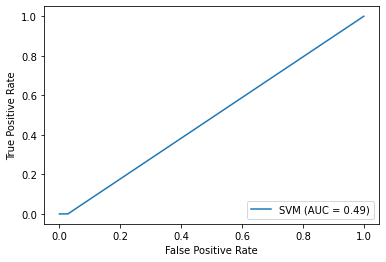

(array([0, 1]), array([36,  4]))


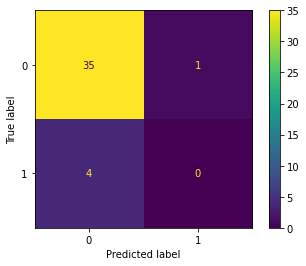

In [15]:
X_train_diag,X_test_diag,Y_train_diag,Y_test_diag = make_train_test_diag_split(CN,AD)

#Create a svm Classifier
svc = svm.SVC()
parameters = {'kernel':['linear'], 'C': [i for i in np.arange(0.00001,.01,0.001)]}

for score in scoring:
    print( " tuning for scoring %s " % score)
    clf = GridSearchCV(svc, parameters,cv=StratifiedKFold(5,shuffle=True,random_state=55),refit=True,scoring="%s" % score)

    #y_score = clf.fit(X_train, Y_train.sex).decision_function(X_test)
    clf.fit(X_train_diag, Y_train_diag.diag)
    print("best parameters", clf.best_params_)
    print("cross validation results", clf.cv_results_)
    print("Best scores ", clf.best_score_)
    y_pred = clf.predict(X_test_diag)
    print(" F1 score on test set ---- " , f1_score(Y_test_diag.diag, y_pred, average='weighted'))

    plotting_roc_auc_curve(Y_test_diag.diag,y_pred)
    create_confusion_matrix(Y_test_diag.diag,y_pred,clf)

### CN vs ADR

/tmp/ipykernel_47077/550404812.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test['diag'] = Y_test['diag'].astype('int')
/tmp/ipykernel_47077/550404812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train['diag'] = Y_train['diag'].astype('int')


number of training samples (array([0, 1]), array([116,  36]))
number of testing samples (array([0, 1]), array([36, 15]))
 tuning for scoring f1_weighted 
best parameters {'C': 0.00201, 'kernel': 'linear'}
cross validation results {'mean_fit_time': array([1.69417949, 1.73596587, 1.6868576 , 1.77985072, 1.72189636,
       1.70973616, 1.87720227, 1.74396544, 1.69721885, 1.795015  ]), 'std_fit_time': array([0.06075441, 0.12111213, 0.06945401, 0.11135319, 0.07172395,
       0.09989911, 0.1448962 , 0.10235171, 0.05838383, 0.11174162]), 'mean_score_time': array([1.05991755, 0.95438228, 0.99269309, 1.08428001, 0.99377956,
       1.02803488, 0.98054352, 1.08617916, 0.9937675 , 1.03725753]), 'std_score_time': array([0.11307848, 0.04955953, 0.06314148, 0.12081822, 0.06414629,
       0.10403321, 0.06070767, 0.11160659, 0.04865882, 0.10636734]), 'param_C': masked_array(data=[1e-05, 0.00101, 0.00201, 0.00301, 0.00401, 0.00501,
                   0.00601, 0.00701, 0.00801, 0.00901],
             mask

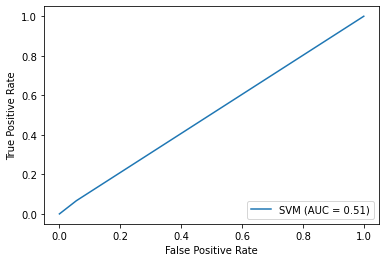

(array([0, 1]), array([36, 15]))


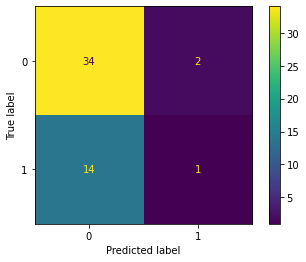

In [16]:
X_train_diag,X_test_diag,Y_train_diag,Y_test_diag = make_train_test_diag_split(CN,ADR)

#Create a svm Classifier
svc = svm.SVC()
for score in scoring:
    print( " tuning for scoring %s " % score)
    clf = GridSearchCV(svc, parameters,cv=StratifiedKFold(5,shuffle=True,random_state=55),refit=True,scoring="%s" % score)

    #y_score = clf.fit(X_train, Y_train.sex).decision_function(X_test)
    clf.fit(X_train_diag, Y_train_diag.diag)
    print("best parameters", clf.best_params_)
    print("cross validation results", clf.cv_results_)
    print("Best scores ", clf.best_score_)
    y_pred = clf.predict(X_test_diag)
    print(" F1 score on test set ---- " , f1_score(Y_test_diag.diag, y_pred, average='weighted'))

    plotting_roc_auc_curve(Y_test_diag.diag,y_pred)
    create_confusion_matrix(Y_test_diag.diag,y_pred,clf)